<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:13:14] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


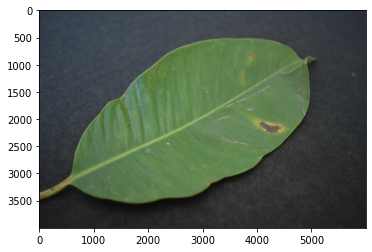

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

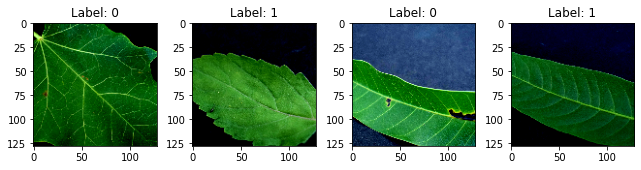

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:13:22] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:13:24] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2573917562419663 samples/sec                   batch loss = 0.4508785009384155 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.267561702646561 samples/sec                   batch loss = 1.235387921333313 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.270231951952734 samples/sec                   batch loss = 0.793194055557251 | accuracy = 0.6666666666666666


Epoch[1] Batch[20] Speed: 1.2647452265095087 samples/sec                   batch loss = 0.9385409951210022 | accuracy = 0.65


Epoch[1] Batch[25] Speed: 1.26790215189177 samples/sec                   batch loss = 0.09981395304203033 | accuracy = 0.65


Epoch[1] Batch[30] Speed: 1.2728156493996023 samples/sec                   batch loss = 0.3950876295566559 | accuracy = 0.675


Epoch[1] Batch[35] Speed: 1.2679889698396793 samples/sec                   batch loss = 0.7659143805503845 | accuracy = 0.65


Epoch[1] Batch[40] Speed: 1.269991376553916 samples/sec                   batch loss = 1.518492579460144 | accuracy = 0.65


Epoch[1] Batch[45] Speed: 1.2690344010774817 samples/sec                   batch loss = 0.7555428147315979 | accuracy = 0.6611111111111111


Epoch[1] Batch[50] Speed: 1.2700138725484778 samples/sec                   batch loss = 0.7254767417907715 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.2661305422118956 samples/sec                   batch loss = 1.1712493896484375 | accuracy = 0.6409090909090909


Epoch[1] Batch[60] Speed: 1.2676140896548322 samples/sec                   batch loss = 0.6682080030441284 | accuracy = 0.65


Epoch[1] Batch[65] Speed: 1.2724093451298224 samples/sec                   batch loss = 0.8616604804992676 | accuracy = 0.65


Epoch[1] Batch[70] Speed: 1.26682185166694 samples/sec                   batch loss = 0.7086957097053528 | accuracy = 0.6428571428571429


Epoch[1] Batch[75] Speed: 1.2750193583551679 samples/sec                   batch loss = 0.596889317035675 | accuracy = 0.6466666666666666


Epoch[1] Batch[80] Speed: 1.2653933148842866 samples/sec                   batch loss = 0.5759156346321106 | accuracy = 0.640625


Epoch[1] Batch[85] Speed: 1.2669664997134882 samples/sec                   batch loss = 0.7170457243919373 | accuracy = 0.6411764705882353


Epoch[1] Batch[90] Speed: 1.2680729243273223 samples/sec                   batch loss = 0.7895230054855347 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.2764132041066243 samples/sec                   batch loss = 0.7721801996231079 | accuracy = 0.6447368421052632


Epoch[1] Batch[100] Speed: 1.2680909434060952 samples/sec                   batch loss = 0.2583930790424347 | accuracy = 0.655


Epoch[1] Batch[105] Speed: 1.2720423595191095 samples/sec                   batch loss = 0.8571629524230957 | accuracy = 0.6476190476190476


Epoch[1] Batch[110] Speed: 1.2731256923959398 samples/sec                   batch loss = 1.0592271089553833 | accuracy = 0.6454545454545455


Epoch[1] Batch[115] Speed: 1.2686906573180359 samples/sec                   batch loss = 0.29674214124679565 | accuracy = 0.6456521739130435


Epoch[1] Batch[120] Speed: 1.2742335178113937 samples/sec                   batch loss = 1.1376715898513794 | accuracy = 0.6458333333333334


Epoch[1] Batch[125] Speed: 1.2673072993679408 samples/sec                   batch loss = 0.8336144685745239 | accuracy = 0.646


Epoch[1] Batch[130] Speed: 1.2704886854356103 samples/sec                   batch loss = 0.6145285367965698 | accuracy = 0.6423076923076924


Epoch[1] Batch[135] Speed: 1.2686833660563777 samples/sec                   batch loss = 0.9896335601806641 | accuracy = 0.6425925925925926


Epoch[1] Batch[140] Speed: 1.2628093107221343 samples/sec                   batch loss = 0.5544995069503784 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.264427625319127 samples/sec                   batch loss = 0.3847062587738037 | accuracy = 0.6482758620689655


Epoch[1] Batch[150] Speed: 1.2641158984280845 samples/sec                   batch loss = 0.39647722244262695 | accuracy = 0.645


Epoch[1] Batch[155] Speed: 1.264993070035394 samples/sec                   batch loss = 0.584391713142395 | accuracy = 0.6451612903225806


Epoch[1] Batch[160] Speed: 1.2663896350773562 samples/sec                   batch loss = 0.6249287128448486 | accuracy = 0.646875


Epoch[1] Batch[165] Speed: 1.2697821250855146 samples/sec                   batch loss = 0.38636305928230286 | accuracy = 0.6454545454545455


Epoch[1] Batch[170] Speed: 1.2635511422838779 samples/sec                   batch loss = 0.4814895987510681 | accuracy = 0.6441176470588236


Epoch[1] Batch[175] Speed: 1.2679686537576418 samples/sec                   batch loss = 0.842133641242981 | accuracy = 0.6442857142857142


Epoch[1] Batch[180] Speed: 1.2718080394335012 samples/sec                   batch loss = 0.9112102389335632 | accuracy = 0.6458333333333334


Epoch[1] Batch[185] Speed: 1.2659058451923548 samples/sec                   batch loss = 0.40991276502609253 | accuracy = 0.6459459459459459


Epoch[1] Batch[190] Speed: 1.270468096758489 samples/sec                   batch loss = 0.5082616209983826 | accuracy = 0.6447368421052632


Epoch[1] Batch[195] Speed: 1.266710135574066 samples/sec                   batch loss = 0.421406626701355 | accuracy = 0.6474358974358975


Epoch[1] Batch[200] Speed: 1.2664898218618226 samples/sec                   batch loss = 0.28600311279296875 | accuracy = 0.65125


Epoch[1] Batch[205] Speed: 1.2718724447458631 samples/sec                   batch loss = 0.444318950176239 | accuracy = 0.65


Epoch[1] Batch[210] Speed: 1.2747565289685965 samples/sec                   batch loss = 0.6481503844261169 | accuracy = 0.6488095238095238


Epoch[1] Batch[215] Speed: 1.2706441803587158 samples/sec                   batch loss = 0.2273038625717163 | accuracy = 0.6511627906976745


Epoch[1] Batch[220] Speed: 1.2799820315022432 samples/sec                   batch loss = 0.5029585957527161 | accuracy = 0.6488636363636363


Epoch[1] Batch[225] Speed: 1.2762029961973034 samples/sec                   batch loss = 1.2060844898223877 | accuracy = 0.6488888888888888


Epoch[1] Batch[230] Speed: 1.275076627493481 samples/sec                   batch loss = 0.8092650771141052 | accuracy = 0.6510869565217391


Epoch[1] Batch[235] Speed: 1.2735841759070612 samples/sec                   batch loss = 0.7816714644432068 | accuracy = 0.648936170212766


Epoch[1] Batch[240] Speed: 1.2690246101526712 samples/sec                   batch loss = 0.9446592926979065 | accuracy = 0.646875


Epoch[1] Batch[245] Speed: 1.2688154852031792 samples/sec                   batch loss = 0.535270094871521 | accuracy = 0.6459183673469387


Epoch[1] Batch[250] Speed: 1.2759231824583925 samples/sec                   batch loss = 0.4865589439868927 | accuracy = 0.648


Epoch[1] Batch[255] Speed: 1.2762979452833765 samples/sec                   batch loss = 0.7051864862442017 | accuracy = 0.6480392156862745


Epoch[1] Batch[260] Speed: 1.2732194111210264 samples/sec                   batch loss = 0.3047322928905487 | accuracy = 0.6519230769230769


Epoch[1] Batch[265] Speed: 1.2745421218707003 samples/sec                   batch loss = 1.217955470085144 | accuracy = 0.6481132075471698


Epoch[1] Batch[270] Speed: 1.2759767481196373 samples/sec                   batch loss = 0.7413114309310913 | accuracy = 0.65


Epoch[1] Batch[275] Speed: 1.2761639721421487 samples/sec                   batch loss = 0.30424371361732483 | accuracy = 0.6527272727272727


Epoch[1] Batch[280] Speed: 1.2761318421867311 samples/sec                   batch loss = 0.8731828927993774 | accuracy = 0.6491071428571429


Epoch[1] Batch[285] Speed: 1.2761734852490407 samples/sec                   batch loss = 0.5053157210350037 | accuracy = 0.6491228070175439


Epoch[1] Batch[290] Speed: 1.268106950144923 samples/sec                   batch loss = 0.5528014302253723 | accuracy = 0.65


Epoch[1] Batch[295] Speed: 1.2708587219008778 samples/sec                   batch loss = 0.3508646488189697 | accuracy = 0.65


Epoch[1] Batch[300] Speed: 1.2687212623436324 samples/sec                   batch loss = 0.3325013816356659 | accuracy = 0.6508333333333334


Epoch[1] Batch[305] Speed: 1.26999551037349 samples/sec                   batch loss = 0.7783265113830566 | accuracy = 0.6532786885245901


Epoch[1] Batch[310] Speed: 1.265458503874243 samples/sec                   batch loss = 1.0442551374435425 | accuracy = 0.6524193548387097


Epoch[1] Batch[315] Speed: 1.2725998675002188 samples/sec                   batch loss = 0.583576500415802 | accuracy = 0.653968253968254


Epoch[1] Batch[320] Speed: 1.2726490998799354 samples/sec                   batch loss = 0.4200376570224762 | accuracy = 0.65390625


Epoch[1] Batch[325] Speed: 1.2748997008731853 samples/sec                   batch loss = 0.3102302849292755 | accuracy = 0.6546153846153846


Epoch[1] Batch[330] Speed: 1.2713358045897838 samples/sec                   batch loss = 0.32733672857284546 | accuracy = 0.6553030303030303


Epoch[1] Batch[335] Speed: 1.2709057016321197 samples/sec                   batch loss = 1.0779813528060913 | accuracy = 0.655223880597015


Epoch[1] Batch[340] Speed: 1.2696910256469442 samples/sec                   batch loss = 1.3826038837432861 | accuracy = 0.6544117647058824


Epoch[1] Batch[345] Speed: 1.271911592479223 samples/sec                   batch loss = 0.5706350207328796 | accuracy = 0.6557971014492754


Epoch[1] Batch[350] Speed: 1.267768306895575 samples/sec                   batch loss = 0.5424233078956604 | accuracy = 0.6557142857142857


Epoch[1] Batch[355] Speed: 1.272372965126266 samples/sec                   batch loss = 0.24764136970043182 | accuracy = 0.6570422535211268


Epoch[1] Batch[360] Speed: 1.2703404426152276 samples/sec                   batch loss = 1.242139220237732 | accuracy = 0.65625


Epoch[1] Batch[365] Speed: 1.266070634316087 samples/sec                   batch loss = 0.42776498198509216 | accuracy = 0.6534246575342466


Epoch[1] Batch[370] Speed: 1.2704830090514596 samples/sec                   batch loss = 0.7343795299530029 | accuracy = 0.654054054054054


Epoch[1] Batch[375] Speed: 1.2602335664901922 samples/sec                   batch loss = 0.6333970427513123 | accuracy = 0.6546666666666666


Epoch[1] Batch[380] Speed: 1.2681513302227478 samples/sec                   batch loss = 0.56280118227005 | accuracy = 0.6572368421052631


Epoch[1] Batch[385] Speed: 1.270938916857636 samples/sec                   batch loss = 1.1411075592041016 | accuracy = 0.6564935064935065


Epoch[1] Batch[390] Speed: 1.2735466652780325 samples/sec                   batch loss = 0.7385538816452026 | accuracy = 0.6551282051282051


Epoch[1] Batch[395] Speed: 1.2780937610675729 samples/sec                   batch loss = 0.14030025899410248 | accuracy = 0.6575949367088607


Epoch[1] Batch[400] Speed: 1.268122094617153 samples/sec                   batch loss = 0.305705189704895 | accuracy = 0.65625


Epoch[1] Batch[405] Speed: 1.2661492705641706 samples/sec                   batch loss = 0.6287722587585449 | accuracy = 0.6574074074074074


Epoch[1] Batch[410] Speed: 1.2665730042314183 samples/sec                   batch loss = 0.49503859877586365 | accuracy = 0.6591463414634147


Epoch[1] Batch[415] Speed: 1.2714191430046589 samples/sec                   batch loss = 0.38685980439186096 | accuracy = 0.6596385542168675


Epoch[1] Batch[420] Speed: 1.2703040846371885 samples/sec                   batch loss = 0.46666058897972107 | accuracy = 0.6595238095238095


Epoch[1] Batch[425] Speed: 1.265141689218782 samples/sec                   batch loss = 0.4473227560520172 | accuracy = 0.6605882352941177


Epoch[1] Batch[430] Speed: 1.2682219805128565 samples/sec                   batch loss = 0.5222854018211365 | accuracy = 0.6616279069767442


Epoch[1] Batch[435] Speed: 1.2672462271452778 samples/sec                   batch loss = 0.49788519740104675 | accuracy = 0.6620689655172414


Epoch[1] Batch[440] Speed: 1.2678031786031856 samples/sec                   batch loss = 0.682711660861969 | accuracy = 0.6625


Epoch[1] Batch[445] Speed: 1.272806186287964 samples/sec                   batch loss = 0.1819159835577011 | accuracy = 0.6629213483146067


Epoch[1] Batch[450] Speed: 1.267339943831963 samples/sec                   batch loss = 0.3069164752960205 | accuracy = 0.6644444444444444


Epoch[1] Batch[455] Speed: 1.2723743160706384 samples/sec                   batch loss = 0.10582153499126434 | accuracy = 0.6648351648351648


Epoch[1] Batch[460] Speed: 1.2652113366664641 samples/sec                   batch loss = 0.6619998216629028 | accuracy = 0.6646739130434782


Epoch[1] Batch[465] Speed: 1.2694389367025203 samples/sec                   batch loss = 0.7870471477508545 | accuracy = 0.6655913978494624


Epoch[1] Batch[470] Speed: 1.264181336893923 samples/sec                   batch loss = 0.43563732504844666 | accuracy = 0.6643617021276595


Epoch[1] Batch[475] Speed: 1.2730048445947955 samples/sec                   batch loss = 0.6634916067123413 | accuracy = 0.6626315789473685


Epoch[1] Batch[480] Speed: 1.2641670484411545 samples/sec                   batch loss = 0.4811081290245056 | accuracy = 0.6630208333333333


Epoch[1] Batch[485] Speed: 1.2647447497975546 samples/sec                   batch loss = 0.6803697347640991 | accuracy = 0.6634020618556701


Epoch[1] Batch[490] Speed: 1.275121206017929 samples/sec                   batch loss = 0.48302552103996277 | accuracy = 0.6627551020408163


Epoch[1] Batch[495] Speed: 1.2710149814501779 samples/sec                   batch loss = 0.3253260552883148 | accuracy = 0.6641414141414141


Epoch[1] Batch[500] Speed: 1.2674965840662689 samples/sec                   batch loss = 0.23616278171539307 | accuracy = 0.665


Epoch[1] Batch[505] Speed: 1.2691865637864892 samples/sec                   batch loss = 0.28255942463874817 | accuracy = 0.6648514851485149


Epoch[1] Batch[510] Speed: 1.264765439427019 samples/sec                   batch loss = 0.43760946393013 | accuracy = 0.6656862745098039


Epoch[1] Batch[515] Speed: 1.264611475230909 samples/sec                   batch loss = 0.5323870182037354 | accuracy = 0.6655339805825242


Epoch[1] Batch[520] Speed: 1.2658472956773572 samples/sec                   batch loss = 0.6650423407554626 | accuracy = 0.6653846153846154


Epoch[1] Batch[525] Speed: 1.2641024686638178 samples/sec                   batch loss = 0.9117594957351685 | accuracy = 0.6638095238095238


Epoch[1] Batch[530] Speed: 1.2669227765497026 samples/sec                   batch loss = 0.546931803226471 | accuracy = 0.6636792452830189


Epoch[1] Batch[535] Speed: 1.2610793834628673 samples/sec                   batch loss = 0.300187349319458 | accuracy = 0.6649532710280374


Epoch[1] Batch[540] Speed: 1.2664237618106253 samples/sec                   batch loss = 0.4727293848991394 | accuracy = 0.6648148148148149


Epoch[1] Batch[545] Speed: 1.26902192247425 samples/sec                   batch loss = 0.27461040019989014 | accuracy = 0.6660550458715596


Epoch[1] Batch[550] Speed: 1.263917909750628 samples/sec                   batch loss = 0.5606792569160461 | accuracy = 0.6663636363636364


Epoch[1] Batch[555] Speed: 1.2645143493058149 samples/sec                   batch loss = 0.4395759105682373 | accuracy = 0.6662162162162162


Epoch[1] Batch[560] Speed: 1.2689668275753674 samples/sec                   batch loss = 0.40463781356811523 | accuracy = 0.6665178571428572


Epoch[1] Batch[565] Speed: 1.266972814467938 samples/sec                   batch loss = 0.8981081247329712 | accuracy = 0.6676991150442478


Epoch[1] Batch[570] Speed: 1.2663436577092329 samples/sec                   batch loss = 0.4585056006908417 | accuracy = 0.6666666666666666


Epoch[1] Batch[575] Speed: 1.2664053121157883 samples/sec                   batch loss = 0.33076658844947815 | accuracy = 0.6673913043478261


Epoch[1] Batch[580] Speed: 1.273270624088859 samples/sec                   batch loss = 2.645646572113037 | accuracy = 0.6676724137931035


Epoch[1] Batch[585] Speed: 1.2711265914259118 samples/sec                   batch loss = 0.4102458655834198 | accuracy = 0.6683760683760683


Epoch[1] Batch[590] Speed: 1.2642253473579634 samples/sec                   batch loss = 0.6987921595573425 | accuracy = 0.6682203389830509


Epoch[1] Batch[595] Speed: 1.2675790368079753 samples/sec                   batch loss = 0.6149821281433105 | accuracy = 0.6684873949579831


Epoch[1] Batch[600] Speed: 1.2705676790283074 samples/sec                   batch loss = 0.2460044026374817 | accuracy = 0.6691666666666667


Epoch[1] Batch[605] Speed: 1.264931648428171 samples/sec                   batch loss = 0.7515155076980591 | accuracy = 0.6694214876033058


Epoch[1] Batch[610] Speed: 1.26918761993279 samples/sec                   batch loss = 0.4735359251499176 | accuracy = 0.669672131147541


Epoch[1] Batch[615] Speed: 1.2643202374844684 samples/sec                   batch loss = 0.5049964785575867 | accuracy = 0.6691056910569105


Epoch[1] Batch[620] Speed: 1.2669248813155793 samples/sec                   batch loss = 0.4241245985031128 | accuracy = 0.6693548387096774


Epoch[1] Batch[625] Speed: 1.2647557142634218 samples/sec                   batch loss = 0.49128085374832153 | accuracy = 0.6708


Epoch[1] Batch[630] Speed: 1.2685136760224363 samples/sec                   batch loss = 1.0003753900527954 | accuracy = 0.6718253968253968


Epoch[1] Batch[635] Speed: 1.2633064317862088 samples/sec                   batch loss = 0.7045750021934509 | accuracy = 0.6720472440944882


Epoch[1] Batch[640] Speed: 1.267395089033793 samples/sec                   batch loss = 0.30165037512779236 | accuracy = 0.67421875


Epoch[1] Batch[645] Speed: 1.2676113121727501 samples/sec                   batch loss = 0.7289135456085205 | accuracy = 0.674031007751938


Epoch[1] Batch[650] Speed: 1.263111549450591 samples/sec                   batch loss = 0.7136185169219971 | accuracy = 0.6738461538461539


Epoch[1] Batch[655] Speed: 1.2672504388337276 samples/sec                   batch loss = 0.31529608368873596 | accuracy = 0.6729007633587786


Epoch[1] Batch[660] Speed: 1.2657944815934032 samples/sec                   batch loss = 0.5806016325950623 | accuracy = 0.6738636363636363


Epoch[1] Batch[665] Speed: 1.2742511317121379 samples/sec                   batch loss = 0.4142661988735199 | accuracy = 0.674436090225564


Epoch[1] Batch[670] Speed: 1.2631573875196809 samples/sec                   batch loss = 0.521106481552124 | accuracy = 0.6746268656716418


Epoch[1] Batch[675] Speed: 1.2740232531879216 samples/sec                   batch loss = 0.49819448590278625 | accuracy = 0.6751851851851852


Epoch[1] Batch[680] Speed: 1.2709978420511763 samples/sec                   batch loss = 0.7194655537605286 | accuracy = 0.674264705882353


Epoch[1] Batch[685] Speed: 1.2688056976560484 samples/sec                   batch loss = 0.442608505487442 | accuracy = 0.6744525547445256


Epoch[1] Batch[690] Speed: 1.2666631786124596 samples/sec                   batch loss = 0.33504432439804077 | accuracy = 0.6760869565217391


Epoch[1] Batch[695] Speed: 1.2639070550222276 samples/sec                   batch loss = 0.8511123657226562 | accuracy = 0.6766187050359712


Epoch[1] Batch[700] Speed: 1.2640227531714117 samples/sec                   batch loss = 0.9107527732849121 | accuracy = 0.6753571428571429


Epoch[1] Batch[705] Speed: 1.2701805984739556 samples/sec                   batch loss = 0.5253164768218994 | accuracy = 0.675531914893617


Epoch[1] Batch[710] Speed: 1.2731578643823933 samples/sec                   batch loss = 0.8008598685264587 | accuracy = 0.6757042253521127


Epoch[1] Batch[715] Speed: 1.2713567104256198 samples/sec                   batch loss = 0.47312667965888977 | accuracy = 0.6762237762237763


Epoch[1] Batch[720] Speed: 1.2734733905783007 samples/sec                   batch loss = 0.624138593673706 | accuracy = 0.6760416666666667


Epoch[1] Batch[725] Speed: 1.2699873388956604 samples/sec                   batch loss = 0.5056185126304626 | accuracy = 0.6765517241379311


Epoch[1] Batch[730] Speed: 1.2746199741022315 samples/sec                   batch loss = 0.46699994802474976 | accuracy = 0.6773972602739726


Epoch[1] Batch[735] Speed: 1.276114079189857 samples/sec                   batch loss = 0.45137736201286316 | accuracy = 0.6772108843537415


Epoch[1] Batch[740] Speed: 1.2683487297965126 samples/sec                   batch loss = 0.8157666325569153 | accuracy = 0.6773648648648649


Epoch[1] Batch[745] Speed: 1.2710156554809335 samples/sec                   batch loss = 0.45976582169532776 | accuracy = 0.6788590604026845


Epoch[1] Batch[750] Speed: 1.2767988461546071 samples/sec                   batch loss = 2.196805953979492 | accuracy = 0.6786666666666666


Epoch[1] Batch[755] Speed: 1.2730638649150712 samples/sec                   batch loss = 1.0156532526016235 | accuracy = 0.6781456953642384


Epoch[1] Batch[760] Speed: 1.275777064231206 samples/sec                   batch loss = 0.6175512075424194 | accuracy = 0.6782894736842106


Epoch[1] Batch[765] Speed: 1.2705819200875832 samples/sec                   batch loss = 0.24998964369297028 | accuracy = 0.6787581699346406


Epoch[1] Batch[770] Speed: 1.269121278155169 samples/sec                   batch loss = 0.21862317621707916 | accuracy = 0.6792207792207792


Epoch[1] Batch[775] Speed: 1.2731812456450051 samples/sec                   batch loss = 0.31365612149238586 | accuracy = 0.68


Epoch[1] Batch[780] Speed: 1.2718253935163741 samples/sec                   batch loss = 0.5902816653251648 | accuracy = 0.6801282051282052


Epoch[1] Batch[785] Speed: 1.2759193980980779 samples/sec                   batch loss = 0.388095498085022 | accuracy = 0.6792993630573249


[Epoch 1] training: accuracy=0.6789340101522843
[Epoch 1] time cost: 648.1680920124054
[Epoch 1] validation: validation accuracy=0.7888888888888889


Epoch[2] Batch[5] Speed: 1.2711202351977806 samples/sec                   batch loss = 0.5313495993614197 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2700808845711422 samples/sec                   batch loss = 0.6829336285591125 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.270002624451577 samples/sec                   batch loss = 0.7496784925460815 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.264295370321039 samples/sec                   batch loss = 0.26875340938568115 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2687659732796501 samples/sec                   batch loss = 0.2074519395828247 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2692455186420541 samples/sec                   batch loss = 0.43961814045906067 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2731890717966337 samples/sec                   batch loss = 0.32843759655952454 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2712073017898355 samples/sec                   batch loss = 0.5212442874908447 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.269825565285352 samples/sec                   batch loss = 0.3912510275840759 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2661673305714531 samples/sec                   batch loss = 0.418038547039032 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.2657132157256938 samples/sec                   batch loss = 0.47830185294151306 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2647769763346441 samples/sec                   batch loss = 0.6525633335113525 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2684872050173894 samples/sec                   batch loss = 0.8010401725769043 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2634714963084395 samples/sec                   batch loss = 0.4594525098800659 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2652077109936892 samples/sec                   batch loss = 0.2541295289993286 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2694494063923072 samples/sec                   batch loss = 0.3956316411495209 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2684876845547566 samples/sec                   batch loss = 0.7169153690338135 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.2730853106422475 samples/sec                   batch loss = 0.6002579927444458 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2668074078095553 samples/sec                   batch loss = 0.1589965522289276 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.2716684527048057 samples/sec                   batch loss = 0.6500088572502136 | accuracy = 0.75


Epoch[2] Batch[105] Speed: 1.2690540793735188 samples/sec                   batch loss = 0.45793941617012024 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.2668584888884191 samples/sec                   batch loss = 0.917262852191925 | accuracy = 0.7477272727272727


Epoch[2] Batch[115] Speed: 1.2700543481181945 samples/sec                   batch loss = 0.48741796612739563 | accuracy = 0.7478260869565218


Epoch[2] Batch[120] Speed: 1.2675480080365906 samples/sec                   batch loss = 0.32031965255737305 | accuracy = 0.74375


Epoch[2] Batch[125] Speed: 1.2588056738789144 samples/sec                   batch loss = 0.3891320824623108 | accuracy = 0.748


Epoch[2] Batch[130] Speed: 1.2640407525650799 samples/sec                   batch loss = 0.5008204579353333 | accuracy = 0.7423076923076923


Epoch[2] Batch[135] Speed: 1.2600754037679653 samples/sec                   batch loss = 0.5359795093536377 | accuracy = 0.7388888888888889


Epoch[2] Batch[140] Speed: 1.2633760675812025 samples/sec                   batch loss = 0.4996953010559082 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.2639426668462697 samples/sec                   batch loss = 0.5111098885536194 | accuracy = 0.7448275862068966


Epoch[2] Batch[150] Speed: 1.265441514002797 samples/sec                   batch loss = 0.07588693499565125 | accuracy = 0.745


Epoch[2] Batch[155] Speed: 1.2692946838822077 samples/sec                   batch loss = 0.38486430048942566 | accuracy = 0.7467741935483871


Epoch[2] Batch[160] Speed: 1.264629968020206 samples/sec                   batch loss = 0.45018818974494934 | accuracy = 0.75


Epoch[2] Batch[165] Speed: 1.2654094444775472 samples/sec                   batch loss = 0.7382233142852783 | accuracy = 0.7484848484848485


Epoch[2] Batch[170] Speed: 1.2702413768248932 samples/sec                   batch loss = 0.2534385621547699 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.273611053438216 samples/sec                   batch loss = 0.9368715882301331 | accuracy = 0.7471428571428571


Epoch[2] Batch[180] Speed: 1.2714065211091536 samples/sec                   batch loss = 0.5234795808792114 | accuracy = 0.7430555555555556


Epoch[2] Batch[185] Speed: 1.2719653040050432 samples/sec                   batch loss = 0.501353919506073 | accuracy = 0.7432432432432432


Epoch[2] Batch[190] Speed: 1.267720313534019 samples/sec                   batch loss = 0.2948751747608185 | accuracy = 0.7421052631578947


Epoch[2] Batch[195] Speed: 1.2657390936181452 samples/sec                   batch loss = 0.2856771945953369 | accuracy = 0.7487179487179487


Epoch[2] Batch[200] Speed: 1.275958116075177 samples/sec                   batch loss = 0.4184184670448303 | accuracy = 0.74875


Epoch[2] Batch[205] Speed: 1.2733519935401956 samples/sec                   batch loss = 0.2930455207824707 | accuracy = 0.751219512195122


Epoch[2] Batch[210] Speed: 1.2711426748931378 samples/sec                   batch loss = 0.4881778657436371 | accuracy = 0.7523809523809524


Epoch[2] Batch[215] Speed: 1.2677428249377527 samples/sec                   batch loss = 0.19202201068401337 | accuracy = 0.7476744186046511


Epoch[2] Batch[220] Speed: 1.2645330298754425 samples/sec                   batch loss = 0.47099387645721436 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.260129161388343 samples/sec                   batch loss = 0.357321560382843 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2629080761995666 samples/sec                   batch loss = 0.3070381283760071 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.262307357087309 samples/sec                   batch loss = 0.9565504789352417 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2581718623988514 samples/sec                   batch loss = 0.6788946986198425 | accuracy = 0.746875


Epoch[2] Batch[245] Speed: 1.2609444161933332 samples/sec                   batch loss = 0.7038895487785339 | accuracy = 0.7479591836734694


Epoch[2] Batch[250] Speed: 1.2630543991738044 samples/sec                   batch loss = 0.4489341080188751 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.2588078462102807 samples/sec                   batch loss = 0.48997944593429565 | accuracy = 0.7450980392156863


Epoch[2] Batch[260] Speed: 1.2625121568941442 samples/sec                   batch loss = 0.3527047336101532 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.264525881633098 samples/sec                   batch loss = 0.2867731750011444 | accuracy = 0.7471698113207547


Epoch[2] Batch[270] Speed: 1.2619125736081118 samples/sec                   batch loss = 0.292175829410553 | accuracy = 0.75


Epoch[2] Batch[275] Speed: 1.2633543769202427 samples/sec                   batch loss = 0.6507397890090942 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.2666764715741738 samples/sec                   batch loss = 0.3313196301460266 | accuracy = 0.7517857142857143


Epoch[2] Batch[285] Speed: 1.2615390006186176 samples/sec                   batch loss = 0.790322482585907 | accuracy = 0.7491228070175439


Epoch[2] Batch[290] Speed: 1.2662127217532424 samples/sec                   batch loss = 0.2992943823337555 | accuracy = 0.75


Epoch[2] Batch[295] Speed: 1.2588213526126528 samples/sec                   batch loss = 0.7226291298866272 | accuracy = 0.75


Epoch[2] Batch[300] Speed: 1.2633066220374856 samples/sec                   batch loss = 0.2888455092906952 | accuracy = 0.7516666666666667


Epoch[2] Batch[305] Speed: 1.2574571601021332 samples/sec                   batch loss = 0.4290314316749573 | accuracy = 0.75


Epoch[2] Batch[310] Speed: 1.2596655581071727 samples/sec                   batch loss = 0.6223347187042236 | accuracy = 0.7491935483870967


Epoch[2] Batch[315] Speed: 1.2558115999958084 samples/sec                   batch loss = 1.0607823133468628 | accuracy = 0.75


Epoch[2] Batch[320] Speed: 1.2658620996923928 samples/sec                   batch loss = 0.3259475529193878 | accuracy = 0.75234375


Epoch[2] Batch[325] Speed: 1.2666232057754918 samples/sec                   batch loss = 0.5104909539222717 | accuracy = 0.7507692307692307


Epoch[2] Batch[330] Speed: 1.255303734025985 samples/sec                   batch loss = 0.4007036089897156 | accuracy = 0.7507575757575757


Epoch[2] Batch[335] Speed: 1.25843063411426 samples/sec                   batch loss = 0.45251017808914185 | accuracy = 0.7492537313432835


Epoch[2] Batch[340] Speed: 1.2628768003779323 samples/sec                   batch loss = 0.7300251722335815 | accuracy = 0.7470588235294118


Epoch[2] Batch[345] Speed: 1.2601089070984897 samples/sec                   batch loss = 0.5161969661712646 | accuracy = 0.7471014492753624


Epoch[2] Batch[350] Speed: 1.2654449501197695 samples/sec                   batch loss = 0.3567343056201935 | accuracy = 0.7478571428571429


Epoch[2] Batch[355] Speed: 1.2665218505611027 samples/sec                   batch loss = 0.22576001286506653 | accuracy = 0.747887323943662


Epoch[2] Batch[360] Speed: 1.2657678374623225 samples/sec                   batch loss = 0.3327783942222595 | accuracy = 0.7493055555555556


Epoch[2] Batch[365] Speed: 1.2729956684408352 samples/sec                   batch loss = 0.5125986933708191 | accuracy = 0.7479452054794521


Epoch[2] Batch[370] Speed: 1.2664617144275436 samples/sec                   batch loss = 0.6790106296539307 | accuracy = 0.7479729729729729


Epoch[2] Batch[375] Speed: 1.2695226990566213 samples/sec                   batch loss = 0.4029196500778198 | accuracy = 0.7486666666666667


Epoch[2] Batch[380] Speed: 1.2677458903822345 samples/sec                   batch loss = 0.2103227823972702 | accuracy = 0.75


Epoch[2] Batch[385] Speed: 1.2614271710185105 samples/sec                   batch loss = 0.2735392153263092 | accuracy = 0.7512987012987012


Epoch[2] Batch[390] Speed: 1.2602290226624224 samples/sec                   batch loss = 0.2645799517631531 | accuracy = 0.7519230769230769


Epoch[2] Batch[395] Speed: 1.263531253638527 samples/sec                   batch loss = 0.40166032314300537 | accuracy = 0.7512658227848101


Epoch[2] Batch[400] Speed: 1.265423951918582 samples/sec                   batch loss = 0.536767303943634 | accuracy = 0.750625


Epoch[2] Batch[405] Speed: 1.2645146352287417 samples/sec                   batch loss = 0.37967193126678467 | accuracy = 0.7506172839506173


Epoch[2] Batch[410] Speed: 1.2569737657960691 samples/sec                   batch loss = 0.31285473704338074 | accuracy = 0.7518292682926829


Epoch[2] Batch[415] Speed: 1.260111367865313 samples/sec                   batch loss = 0.14550898969173431 | accuracy = 0.7512048192771085


Epoch[2] Batch[420] Speed: 1.2618240233549887 samples/sec                   batch loss = 0.4051859378814697 | accuracy = 0.75


Epoch[2] Batch[425] Speed: 1.2689457123317365 samples/sec                   batch loss = 0.5890614986419678 | accuracy = 0.7488235294117647


Epoch[2] Batch[430] Speed: 1.2715977070456081 samples/sec                   batch loss = 0.24577394127845764 | accuracy = 0.7494186046511628


Epoch[2] Batch[435] Speed: 1.2722573735112859 samples/sec                   batch loss = 0.46463075280189514 | accuracy = 0.7505747126436781


Epoch[2] Batch[440] Speed: 1.2760113935238597 samples/sec                   batch loss = 0.8165898323059082 | accuracy = 0.7511363636363636


Epoch[2] Batch[445] Speed: 1.270851116902178 samples/sec                   batch loss = 0.7026906609535217 | accuracy = 0.750561797752809


Epoch[2] Batch[450] Speed: 1.2650826380068099 samples/sec                   batch loss = 0.09802740812301636 | accuracy = 0.75


Epoch[2] Batch[455] Speed: 1.2705509365696006 samples/sec                   batch loss = 0.38314467668533325 | accuracy = 0.7489010989010989


Epoch[2] Batch[460] Speed: 1.2712125030478552 samples/sec                   batch loss = 0.5116387009620667 | accuracy = 0.7489130434782608


Epoch[2] Batch[465] Speed: 1.2700832882901296 samples/sec                   batch loss = 0.435467004776001 | accuracy = 0.75


Epoch[2] Batch[470] Speed: 1.2701983890030717 samples/sec                   batch loss = 0.33290642499923706 | accuracy = 0.749468085106383


Epoch[2] Batch[475] Speed: 1.269663064200821 samples/sec                   batch loss = 0.4500550925731659 | accuracy = 0.7505263157894737


Epoch[2] Batch[480] Speed: 1.264954060901133 samples/sec                   batch loss = 0.8013409972190857 | accuracy = 0.7489583333333333


Epoch[2] Batch[485] Speed: 1.2737584166089218 samples/sec                   batch loss = 0.22344490885734558 | accuracy = 0.7494845360824742


Epoch[2] Batch[490] Speed: 1.2663042785015368 samples/sec                   batch loss = 0.2567819654941559 | accuracy = 0.7484693877551021


Epoch[2] Batch[495] Speed: 1.26785836412632 samples/sec                   batch loss = 0.4437768757343292 | accuracy = 0.7494949494949495


Epoch[2] Batch[500] Speed: 1.268942929011132 samples/sec                   batch loss = 0.3742534816265106 | accuracy = 0.75


Epoch[2] Batch[505] Speed: 1.2687592568434944 samples/sec                   batch loss = 0.1810314804315567 | accuracy = 0.7514851485148515


Epoch[2] Batch[510] Speed: 1.271207205470644 samples/sec                   batch loss = 0.4503186345100403 | accuracy = 0.7524509803921569


Epoch[2] Batch[515] Speed: 1.2675902420154253 samples/sec                   batch loss = 0.8337570428848267 | accuracy = 0.7519417475728155


Epoch[2] Batch[520] Speed: 1.270117325927578 samples/sec                   batch loss = 0.3225517272949219 | accuracy = 0.7538461538461538


Epoch[2] Batch[525] Speed: 1.2756916985528457 samples/sec                   batch loss = 0.29917579889297485 | accuracy = 0.7557142857142857


Epoch[2] Batch[530] Speed: 1.2717434478425893 samples/sec                   batch loss = 0.3389829397201538 | accuracy = 0.7570754716981132


Epoch[2] Batch[535] Speed: 1.2607599255291768 samples/sec                   batch loss = 0.7712851762771606 | accuracy = 0.7560747663551401


Epoch[2] Batch[540] Speed: 1.2732741994876309 samples/sec                   batch loss = 0.684516966342926 | accuracy = 0.7569444444444444


Epoch[2] Batch[545] Speed: 1.2681741445169277 samples/sec                   batch loss = 0.6095154881477356 | accuracy = 0.7573394495412844


Epoch[2] Batch[550] Speed: 1.2605836343682804 samples/sec                   batch loss = 0.32942280173301697 | accuracy = 0.7581818181818182


Epoch[2] Batch[555] Speed: 1.266519269083528 samples/sec                   batch loss = 0.7581467032432556 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.264177717122007 samples/sec                   batch loss = 0.3602731227874756 | accuracy = 0.7589285714285714


Epoch[2] Batch[565] Speed: 1.2642570710863226 samples/sec                   batch loss = 0.41890841722488403 | accuracy = 0.7588495575221239


Epoch[2] Batch[570] Speed: 1.2628207169179593 samples/sec                   batch loss = 0.322298139333725 | accuracy = 0.7596491228070176


Epoch[2] Batch[575] Speed: 1.2638945818364784 samples/sec                   batch loss = 0.18819330632686615 | accuracy = 0.7613043478260869


Epoch[2] Batch[580] Speed: 1.2655331501752203 samples/sec                   batch loss = 0.3122943341732025 | accuracy = 0.7625


Epoch[2] Batch[585] Speed: 1.261443199659068 samples/sec                   batch loss = 0.45370957255363464 | accuracy = 0.7628205128205128


Epoch[2] Batch[590] Speed: 1.2592933141370575 samples/sec                   batch loss = 0.7386819124221802 | accuracy = 0.7635593220338983


Epoch[2] Batch[595] Speed: 1.2654263380427122 samples/sec                   batch loss = 0.4855155050754547 | accuracy = 0.7630252100840336


Epoch[2] Batch[600] Speed: 1.2595794979104629 samples/sec                   batch loss = 0.588860034942627 | accuracy = 0.7620833333333333


Epoch[2] Batch[605] Speed: 1.260772621153639 samples/sec                   batch loss = 0.21344386041164398 | accuracy = 0.7628099173553718


Epoch[2] Batch[610] Speed: 1.2626361519602216 samples/sec                   batch loss = 0.21058747172355652 | accuracy = 0.7639344262295082


Epoch[2] Batch[615] Speed: 1.260190590763163 samples/sec                   batch loss = 0.9117217063903809 | accuracy = 0.7638211382113821


Epoch[2] Batch[620] Speed: 1.267480496977109 samples/sec                   batch loss = 0.20798063278198242 | accuracy = 0.7649193548387097


Epoch[2] Batch[625] Speed: 1.2664885789897256 samples/sec                   batch loss = 0.7187196612358093 | accuracy = 0.7652


Epoch[2] Batch[630] Speed: 1.272070232961685 samples/sec                   batch loss = 0.9434150457382202 | accuracy = 0.7642857142857142


Epoch[2] Batch[635] Speed: 1.2645331251858862 samples/sec                   batch loss = 0.502444326877594 | accuracy = 0.7645669291338583


Epoch[2] Batch[640] Speed: 1.2644697469125954 samples/sec                   batch loss = 0.39775294065475464 | accuracy = 0.766015625


Epoch[2] Batch[645] Speed: 1.2651120198270973 samples/sec                   batch loss = 0.3570994734764099 | accuracy = 0.7662790697674419


Epoch[2] Batch[650] Speed: 1.263222251218745 samples/sec                   batch loss = 0.19304725527763367 | accuracy = 0.7661538461538462


Epoch[2] Batch[655] Speed: 1.2676546997483236 samples/sec                   batch loss = 1.1647582054138184 | accuracy = 0.766412213740458


Epoch[2] Batch[660] Speed: 1.2659772007813839 samples/sec                   batch loss = 0.20043176412582397 | accuracy = 0.7670454545454546


Epoch[2] Batch[665] Speed: 1.2634873866391074 samples/sec                   batch loss = 0.6009855270385742 | accuracy = 0.7672932330827068


Epoch[2] Batch[670] Speed: 1.265484753168027 samples/sec                   batch loss = 0.5598291158676147 | accuracy = 0.7675373134328358


Epoch[2] Batch[675] Speed: 1.2688486872232583 samples/sec                   batch loss = 0.5415275692939758 | accuracy = 0.7670370370370371


Epoch[2] Batch[680] Speed: 1.2680579727145433 samples/sec                   batch loss = 0.3174132704734802 | accuracy = 0.7665441176470589


Epoch[2] Batch[685] Speed: 1.2673866637618199 samples/sec                   batch loss = 0.6026037931442261 | accuracy = 0.7649635036496351


Epoch[2] Batch[690] Speed: 1.2643270975637695 samples/sec                   batch loss = 0.3419620096683502 | accuracy = 0.7655797101449275


Epoch[2] Batch[695] Speed: 1.2705206280684889 samples/sec                   batch loss = 0.21109670400619507 | accuracy = 0.7654676258992805


Epoch[2] Batch[700] Speed: 1.2688669202855227 samples/sec                   batch loss = 0.46623340249061584 | accuracy = 0.7639285714285714


Epoch[2] Batch[705] Speed: 1.2739253533546433 samples/sec                   batch loss = 0.4362613558769226 | accuracy = 0.7638297872340426


Epoch[2] Batch[710] Speed: 1.2696135821855916 samples/sec                   batch loss = 0.8724592328071594 | accuracy = 0.7623239436619719


Epoch[2] Batch[715] Speed: 1.2705339059005192 samples/sec                   batch loss = 0.2139510214328766 | accuracy = 0.7615384615384615


Epoch[2] Batch[720] Speed: 1.2665086564529473 samples/sec                   batch loss = 0.4637688398361206 | accuracy = 0.7618055555555555


Epoch[2] Batch[725] Speed: 1.2687658773300616 samples/sec                   batch loss = 0.4374198913574219 | accuracy = 0.7617241379310344


Epoch[2] Batch[730] Speed: 1.2733360474008553 samples/sec                   batch loss = 0.25491368770599365 | accuracy = 0.7613013698630137


Epoch[2] Batch[735] Speed: 1.2757004286091433 samples/sec                   batch loss = 0.29115453362464905 | accuracy = 0.7622448979591837


Epoch[2] Batch[740] Speed: 1.2730935220353814 samples/sec                   batch loss = 0.22256319224834442 | accuracy = 0.7618243243243243


Epoch[2] Batch[745] Speed: 1.2742225819532091 samples/sec                   batch loss = 0.21951104700565338 | accuracy = 0.7624161073825504


Epoch[2] Batch[750] Speed: 1.2700535789621819 samples/sec                   batch loss = 0.6252282857894897 | accuracy = 0.7626666666666667


Epoch[2] Batch[755] Speed: 1.2730469600087655 samples/sec                   batch loss = 0.6032690405845642 | accuracy = 0.7629139072847683


Epoch[2] Batch[760] Speed: 1.2744864498014001 samples/sec                   batch loss = 0.2286066859960556 | accuracy = 0.7634868421052632


Epoch[2] Batch[765] Speed: 1.2764250516018445 samples/sec                   batch loss = 0.2724970579147339 | accuracy = 0.7640522875816993


Epoch[2] Batch[770] Speed: 1.276879889746947 samples/sec                   batch loss = 0.11795056611299515 | accuracy = 0.7646103896103896


Epoch[2] Batch[775] Speed: 1.2738802780556997 samples/sec                   batch loss = 0.30747485160827637 | accuracy = 0.7638709677419355


Epoch[2] Batch[780] Speed: 1.2719762011517617 samples/sec                   batch loss = 0.5768818259239197 | accuracy = 0.764102564102564


Epoch[2] Batch[785] Speed: 1.2724163897741116 samples/sec                   batch loss = 0.4551742970943451 | accuracy = 0.7636942675159236


[Epoch 2] training: accuracy=0.7636421319796954
[Epoch 2] time cost: 640.2376534938812
[Epoch 2] validation: validation accuracy=0.8


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7333333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)